In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

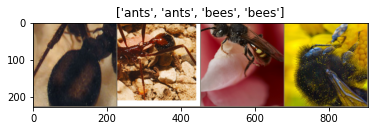

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
from Optimizer.optimizer import Optimizer
optimizer = Optimizer(model_ft, 4, inertial_weight=0.01, self_conf=0.1, swarm_conf=0.01)

def train(dataloader, model, loss_fn, optimizer):
    dataloader_val = dataloader['val']
    dataloader = dataloader['train']
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        best_val = optimizer.step(X, y, loss_fn)

        if batch % 5 == 0:
            loss, current = best_val, batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            test(dataloader_val, model_ft, loss_fn)


In [18]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloaders, model_ft, criterion, optimizer)

print("Done!")

Epoch 1
-------------------------------
loss: 0.592664  [    0/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.865826 

loss: 0.563392  [   20/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.802842 

loss: 0.563392  [   40/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.802842 

loss: 0.563392  [   60/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.826016 

loss: 0.563392  [   80/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.802842 

loss: 0.562624  [  100/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.792133 

loss: 0.562624  [  120/  244]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.814343 

loss: 0.452800  [  140/  244]
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.749364 

loss: 0.232173  [  160/  244]
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.946157 

loss: 0.232173  [  180/  244]
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.946157 

loss: 0.232173  [  200/  244]
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.946156 

loss: 0.214779  [  220/  244]
Test Error: 
 Accuracy: 54.2